# Denoising Pipeline Development

In [ ]:
%load_ext autoreload
%autoreload 2

import fibsem
import salami
from fibsem import utils, acquire, alignment, calibration, milling
from fibsem.structures import BeamType, FibsemPatternSettings, FibsemMillingSettings, FibsemPattern
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

from salami.structures import SalamiSettings, run_salami, create_sweep_parameters



In [ ]:
microscope, settings = utils.setup_session()


In [ ]:
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")
plt.show()


### Move Raw Images to a New Directory

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/data/20230310/raw"


os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(os.path.join(raw_path, "fast"), exist_ok=True)

for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, "fast",  f"{idx:06d}.tif"))

    # copy file with os
    # os.system(f"cp {fname} {os.path.join(raw_path, 'fast',  f'{idx:06d}.tif')}")




/home/patrick/github/salami/data/20230310/raw/fast/000048.tif
/home/patrick/github/salami/data/20230310/raw/fast/000049.tif
/home/patrick/github/salami/data/20230310/raw/fast/000050.tif
/home/patrick/github/salami/data/20230310/raw/fast/000051.tif
/home/patrick/github/salami/data/20230310/raw/fast/000052.tif
/home/patrick/github/salami/data/20230310/raw/fast/000053.tif
/home/patrick/github/salami/data/20230310/raw/fast/000054.tif
/home/patrick/github/salami/data/20230310/raw/fast/000055.tif
/home/patrick/github/salami/data/20230310/raw/fast/000056.tif
/home/patrick/github/salami/data/20230310/raw/fast/000057.tif
/home/patrick/github/salami/data/20230310/raw/fast/000058.tif
/home/patrick/github/salami/data/20230310/raw/fast/000059.tif
/home/patrick/github/salami/data/20230310/raw/fast/000060.tif
/home/patrick/github/salami/data/20230310/raw/fast/000061.tif
/home/patrick/github/salami/data/20230310/raw/fast/000062.tif
/home/patrick/github/salami/data/20230310/raw/fast/000063.tif
/home/pa

In [ ]:

raw_path = "/home/patrick/github/salami/data/20230310/raw"

fast_filenames = sorted(glob.glob(os.path.join(raw_path, "fast", "*.tif")))
slow_filenames = sorted(glob.glob(os.path.join(raw_path, "slow", "*.tif")))


from pprint import pprint

# pprint(fast_filenames)

import math

from salami.denoise.inference import get_window, get_index, get_closest_index

window_size = 5
for idx, fname in enumerate(fast_filenames):

    # idx = get_index(fname) # this is based on the fname which means nothing
    window = get_window(fast_filenames, idx, window_size=window_size)
    if len(window) < window_size:
        continue
    # closest = get_closest_index(window, idx)
    # print(f"index: {idx}, closest: {get_index(closest)}")
    print(f"index: {idx}, window: {[get_index(f) for f in window]}")
    # print(window)
    

## Segmentation Diagnostics

In [23]:
%load_ext autoreload
%autoreload 2

import os
from salami.segmentation import segmentation as sseg

path = "/home/patrick/github/salami/salami/output/seg"

stats = sseg.calc_seg_diagnostic(path, plot=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
print(stats["counts"].shape)

(27, 7)


In [27]:
df = sseg.calculate_diag_df(stats)
display(df)

,Background,Nucleus,Nucleolus,Cytoplasm,Mitochondria,ER,Golgi,fname
0,0.016555,0.008908,0.263841,0.002516,0.116369,0.580973,0.010838,000050.tif
1,0.016977,0.008983,0.262944,0.002512,0.115537,0.582203,0.010845,000051.tif
2,0.017088,0.009034,0.261999,0.002556,0.116118,0.582424,0.010781,000052.tif
3,0.016689,0.008746,0.263413,0.002495,0.115498,0.582034,0.011125,000053.tif
4,0.016745,0.008825,0.265126,0.002527,0.117589,0.578241,0.010947,000054.tif
5,0.016986,0.009069,0.263254,0.002578,0.115686,0.581206,0.011221,000055.tif
6,0.017060,0.009075,0.264293,0.002495,0.116395,0.579491,0.011191,000056.tif
7,0.016990,0.009185,0.264956,0.002521,0.117712,0.577596,0.011040,000057.tif
8,0.017083,0.009130,0.265804,0.002521,0.116574,0.577874,0.011014,000058.tif
9,0.017074,0.009310,0.260009,0.002542,0.115808,0.584433,0.010824,000059.tif


<Axes: xlabel='fname'>

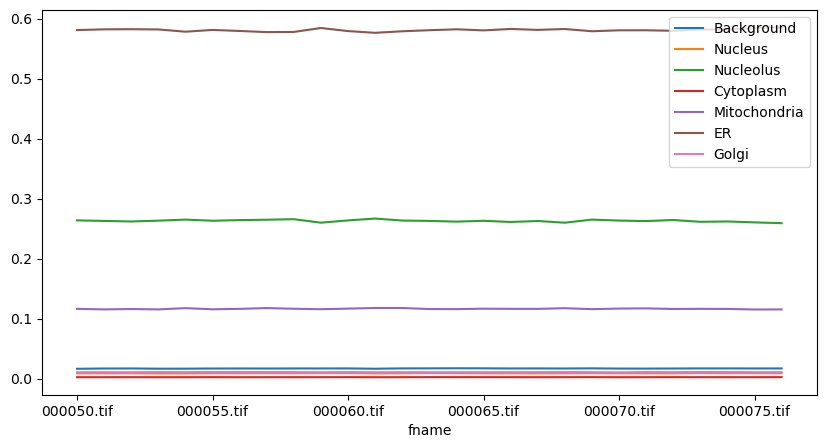

In [32]:
# plot the counts

# get column names except fname

labels = df.columns[:-1]
df.plot(x="fname", y=labels, kind="line", figsize=(10,5)) 
# df.plot(x="fname", y=stats["labels"], kind="line", figsize=(10,5))

## WatchDog Testing

In [11]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
# slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/salami/output2/raw"

# os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(raw_path, exist_ok=True)
import time
for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, f"{idx:06d}.tif"))

    # copy file with os
    os.system(f"cp {fname} {os.path.join(raw_path, f'{idx:06d}.tif')}")

    time.sleep(0.5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/patrick/github/salami/salami/output2/raw/000048.tif
/home/patrick/github/salami/salami/output2/raw/000049.tif
/home/patrick/github/salami/salami/output2/raw/000050.tif
/home/patrick/github/salami/salami/output2/raw/000051.tif
/home/patrick/github/salami/salami/output2/raw/000052.tif
/home/patrick/github/salami/salami/output2/raw/000053.tif
/home/patrick/github/salami/salami/output2/raw/000054.tif
/home/patrick/github/salami/salami/output2/raw/000055.tif
/home/patrick/github/salami/salami/output2/raw/000056.tif
/home/patrick/github/salami/salami/output2/raw/000057.tif
/home/patrick/github/salami/salami/output2/raw/000058.tif
/home/patrick/github/salami/salami/output2/raw/000059.tif
/home/patrick/github/salami/salami/output2/raw/000060.tif
/home/patrick/github/salami/salami/output2/raw/000061.tif
/home/patrick/github/salami/salami/output2/raw/000062.tif
/home/patrick/github/salami/salami/output2

12 45


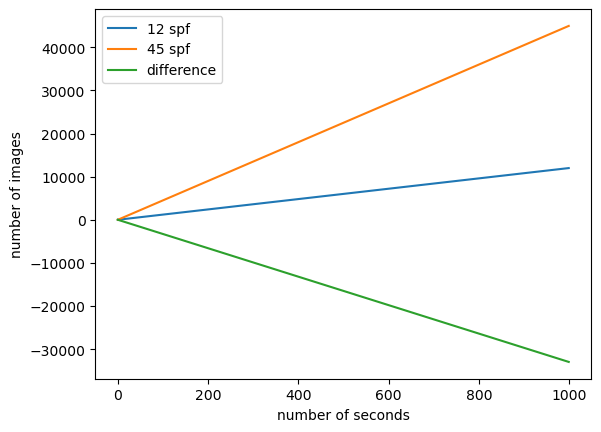

In [20]:
# simulate latency of 45sec vs 12 sec
# plot a graph of 1 image per 12 sec vs 1 image per 45 sec

# 1 per 12
# 1 per 45

fps12 = 1 / 12 # frames per seconds
fps45 = 1 / 45 # frames per seconds 

print(fps12, fps45)

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 1000, 1)
y1 = fps12 * x
y2 = fps45 * x

plt.plot(x, y1, label="12 spf")
plt.plot(x, y2, label="45 spf")
# difference
plt.plot(x, y1 - y2, label="difference")
plt.xlabel("number of seconds")
plt.ylabel("number of images")
plt.legend()
plt.show()